# Da best heart disease classifier in town
- 13516083 / Abram Perdanaputra
- 13516090 / Timothy Thamrin Andrew Hamonangan Sihombing
- 13516093 / Muhammad Farhan
- 13516153 / Dimas Aditia Pratikto
- 13516155 / Restu Wahyu Kartiko

In [1]:
import pandas as pd
from sklearn.model_selection import cross_val_score, train_test_split,GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn import preprocessing
from sklearn.feature_selection import RFE

import matplotlib.pyplot as plt
import numpy as np
import copy
import numbers

%matplotlib inline

#### Functions

In [2]:
# learning curve function

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=5, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()

## Read dataset

Now we're going to read the `tubes2_HeartDisease_train` and `tubes2_HeartDisease_test`

In [3]:
def fix_data(data):
    """Convert dataframe to appropriate types"""
    for x in range(1,5):
        data.loc[data['Column3'] == x, 'Column3'] = str(x)

    num_col = [4, 5, 6, 8, 9, 10, 12]
    
    for col in num_col:
        col_name = 'Column'+str(col)
        data[col_name] = pd.to_numeric(data[col_name], errors='coerce')
    
    return data

def show_data(df, columns):
    data = copy.deepcopy(df)
    data.columns = columns
    
    return data

In [4]:
# data columns and read data from files

heart_disease = {}
heart_disease['columns_detail'] = [
    'Age', 
    'Sex', 
    'Pain type', 
    'Blood pressure', 
    'Serum cholesterol', 
    'Fasting blood sugar > 120mg/dl', 
    'Resting ECG', 
    'Max heart rate achieved', 
    'exercise induced agina', 
    'ST depression induced by exercise relative to rest', 
    'Peak exercise ST segment', 
    'Number of major vessels colored by flourosopy', 
    'Thal', 
    'Diagnosis'
]
heart_disease['train'] = pd.read_csv('../data/tubes2_HeartDisease_train.csv')
heart_disease['test'] = pd.read_csv('../data/tubes2_HeartDisease_test.csv')

In [5]:
heart_disease['train'] = fix_data(heart_disease['train'])
show_data(heart_disease['train'], heart_disease['columns_detail']).head()

,Age,Sex,Pain type,Blood pressure,Serum cholesterol,Fasting blood sugar > 120mg/dl,Resting ECG,Max heart rate achieved,exercise induced agina,ST depression induced by exercise relative to rest,Peak exercise ST segment,Number of major vessels colored by flourosopy,Thal,Diagnosis
0,54,1,4,125.0,216.0,0.0,0,140.0,0.0,0.0,?,NaN,?,1
1,55,1,4,158.0,217.0,0.0,0,110.0,1.0,2.5,2,NaN,?,1
2,54,0,3,135.0,304.0,1.0,0,170.0,0.0,0.0,1,0.0,3,0
3,48,0,3,120.0,195.0,0.0,0,125.0,0.0,0.0,?,NaN,?,0
4,50,1,4,120.0,0.0,0.0,1,156.0,1.0,0.0,1,NaN,6,3


In [6]:
coba = heart_disease['train']

## Data preprocessing

In [7]:
# Helpers
def preprocess_data(data):
    df = copy.deepcopy(data)
    
    # remove infinity and null
    df = df.replace([np.inf, -np.inf], np.nan)
    
    # dropping null values
    null_array = []
    for i, row in df.iterrows():
        if check_null(row) > 3:
            null_array.append(i)
            
    null_array.reverse()
    for i in null_array:
        df = df.drop(df.index[i])

    # remove outliers
    
    # fill null and nan with median
    df.loc[data['Column4'].isnull(), 'Column4'] = data['Column4'].median()
    df.loc[data['Column5'].isnull(), 'Column5'] = data['Column5'].median()
    df.loc[data['Column6'].isnull(), 'Column6'] = data['Column6'].median()
    df.loc[data['Column8'].isnull(), 'Column8'] = data['Column8'].median()
    df.loc[data['Column9'].isnull(), 'Column9'] = data['Column9'].median()
    df.loc[data['Column10'].isnull(), 'Column10'] = data['Column10'].median()
    df.loc[data['Column12'].isnull(), 'Column12'] = data['Column12'].median()
    
    df.loc[np.isnan(data['Column4']), 'Column4'] = data['Column4'].median()
    df.loc[np.isnan(data['Column5']), 'Column5'] = data['Column5'].median()
    df.loc[np.isnan(data['Column6']), 'Column6'] = data['Column6'].median()
    df.loc[np.isnan(data['Column8']), 'Column8'] = data['Column8'].median()
    df.loc[np.isnan(data['Column9']), 'Column9'] = data['Column9'].median()
    df.loc[np.isnan(data['Column10']), 'Column10'] = data['Column10'].median()
    df.loc[np.isnan(data['Column12']), 'Column12'] = data['Column12'].median()
    
    df.loc[data['Column7'] == '?', 'Column7'] = '0'
    df.loc[data['Column11'] == '?', 'Column11'] = '1'
    df.loc[data['Column13'] == '?', 'Column11'] = '0'
    
#     for i, row in df.iterrows():
#         if row['Column11'] == '?':
#             df.loc[i, 'Column11'] = np.random.choice(['1', '2', '3'], \
#                                                size=1,\
#                                                p=[0.5570599613152805, 0.3404255319148936, 0.10251450676982592])[0]
    
#     df.loc[:, 'Column1'] = (df['Column1'] - df['Column1'].mean()) / df['Column1'].std()
#     df.loc[:, 'Column4'] = (df['Column4'] - df['Column4'].mean()) / df['Column4'].std()
#     df.loc[:, 'Column5'] = (df['Column5'] - df['Column5'].mean()) / df['Column5'].std()
#     df.loc[:, 'Column8'] = (df['Column8'] - df['Column8'].mean()) / df['Column8'].std()
#     df.loc[:, 'Column10'] = (df['Column10'] - df['Column10'].mean()) / df['Column10'].std()
    
    
    # Duplicate targets
#     df = df.append([df[df['Column14'] == 4]]*3,ignore_index=True)
#     df = df.append([df[df['Column14'] == 3][:12]],ignore_index=True)
#     df = df.append([df[df['Column14'] == 2][:12]],ignore_index=True)
    
    # dropping bad columns
    df = df.drop(['Column12', 'Column13'], axis=1)
    
    df = pd.get_dummies(df)
    
    return df

def check_null(row):
    sum = 0
    for column in row:
        if isinstance(column, numbers.Number) and np.isnan(column):
            sum += 1
        if not(isinstance(column, numbers.Number)) and column == '?':
            sum += 1
        if column == None:
            sum += 1
    return sum

def check_outlier(row):
    outlier = False
    for column in row:
        if isinstance(column, numbers.Number) and np.isnan(column):
            sum += 1
        if not(isinstance(column, numbers.Number)) and column == '?':
            sum += 1
    return sum

In [8]:
df = preprocess_data(heart_disease['train'])

#### Data Distribution on Target

In [9]:
df['Column14'].value_counts()

0    318
1    209
2     87
3     77
4     21
Name: Column14, dtype: int64

## Experiment

In [10]:
cv = 5

### K-Nearest Neighbor

#### Hyperparameters

In [11]:
num_neighbor = 5

#### Preprocess

In [12]:
df.head()

,Column1,Column2,Column4,Column5,Column6,Column8,Column9,Column10,Column14,Column3_1,Column3_2,Column3_3,Column3_4,Column7_0,Column7_1,Column7_2,Column11_0,Column11_1,Column11_2,Column11_3
0,54,1,125.0,216.0,0.0,140.0,0.0,0.0,1,0,0,0,1,1,0,0,1,0,0,0
1,55,1,158.0,217.0,0.0,110.0,1.0,2.5,1,0,0,0,1,1,0,0,1,0,0,0
2,54,0,135.0,304.0,1.0,170.0,0.0,0.0,0,0,0,1,0,1,0,0,0,1,0,0
3,48,0,120.0,195.0,0.0,125.0,0.0,0.0,0,0,0,1,0,1,0,0,1,0,0,0
4,50,1,120.0,0.0,0.0,156.0,1.0,0.0,3,0,0,0,1,0,1,0,0,1,0,0


#### F1 Score

In [13]:
knn = KNeighborsClassifier(n_neighbors=num_neighbor, algorithm='ball_tree')

# train
X_train, X_test, y_train, y_test = train_test_split(df.drop('Column14', axis=1), df.Column14,test_size=0.2)
knn.fit(X_train,y_train)

knn_f1_scores = cross_val_score(knn, df.loc[:, df.columns != 'Column14']\
                , df['Column14'], cv=cv, scoring='f1_micro')
knn_accuracy_scores = cross_val_score(knn, df.loc[:, df.columns != 'Column14']\
                , df['Column14'], cv=cv, scoring='accuracy')
print("F1 Score: {:.4f} +- {:.4f}".format(knn_f1_scores.mean(), knn_f1_scores.std()))
print("Accuracy Score: {:.4f} +- {:.4f}".format(knn_accuracy_scores.mean(), knn_accuracy_scores.std()))

F1 Score: 0.4889 +- 0.0130
Accuracy Score: 0.4889 +- 0.0130


### Naive Bayes

#### Hyperparameters

#### Preprocess

#### F1 Score

In [14]:
gnb = GaussianNB()

# train
X_train,X_test,y_train,y_test=X_train, X_test, y_train, y_test = train_test_split(df.drop('Column14', axis=1), df.Column14,test_size=0.2)

gnb_f1_scores = cross_val_score(gnb, df.loc[:, df.columns != 'Column14']\
                , df['Column14'], cv=cv, scoring='f1_micro')
gnb_accuracy_scores = cross_val_score(gnb, df.loc[:, df.columns != 'Column14']\
                , df['Column14'], cv=cv, scoring='accuracy')
print("F1 Score: {:.4f} +- {:.4f}".format(gnb_f1_scores.mean(), gnb_f1_scores.std()))
print("Accuracy Score: {:.4f} +- {:.4f}".format(gnb_accuracy_scores.mean(), gnb_accuracy_scores.std()))

F1 Score: 0.4211 +- 0.0439
Accuracy Score: 0.4211 +- 0.0439


### Decision Tree (ID3)

In [15]:
rand = 5

#### F1 Score

In [16]:
id3 = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=8, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=8, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

# train
X_train, X_test, y_train, y_test = train_test_split(df.drop('Column14', axis=1), df.Column14,test_size=0.2)
id3.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=8,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best')

In [17]:
# scores
id3_f1_scores = cross_val_score(id3, df.loc[:, df.columns != 'Column14']\
                , df['Column14'], cv=cv, scoring='f1_micro')
id3_accuracy_scores = cross_val_score(id3, df.loc[:, df.columns != 'Column14']\
                , df['Column14'], cv=cv, scoring='accuracy')
print("F1 Score: {:.4f} +- {:.4f}".format(id3_f1_scores.mean(), id3_f1_scores.std()))
print("Accuracy Score: {:.4f} +- {:.4f}".format(id3_accuracy_scores.mean(), id3_accuracy_scores.std()))

F1 Score: 0.5701 +- 0.0124
Accuracy Score: 0.5701 +- 0.0124


In [18]:
parameters = {'max_depth':[3,6,9,12,15], 'min_samples_split':[2,4,8,16], 'min_samples_leaf':[1,2,4,8,16], 'max_features':[2,4,8,10]}
grid_search = GridSearchCV(id3, parameters, cv=5)
grid_search.fit(X_train,y_train)


print(id3.score(X_test,y_test))
print(grid_search.score(X_test,y_test))

0.6223776223776224
0.6153846153846154


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [19]:
grid_search.best_params_

{'max_depth': 3,
 'max_features': 4,
 'min_samples_leaf': 16,
 'min_samples_split': 2}

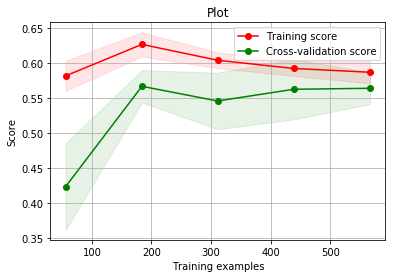

In [20]:
plot_learning_curve(id3, "Plot", df.drop("Column14",axis=1), df['Column14'])

In [21]:
print(classification_report(id3.predict(X_test),y_test))

              precision    recall  f1-score   support

           0       0.96      0.75      0.84        85
           1       0.65      0.43      0.52        51
           2       0.12      0.75      0.20         4
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         0

   micro avg       0.62      0.62      0.62       143
   macro avg       0.34      0.39      0.31       143
weighted avg       0.80      0.62      0.69       143



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [22]:
id3.feature_importances_

array([0.        , 0.        , 0.        , 0.20510843, 0.        ,
       0.        , 0.19246057, 0.04246772, 0.        , 0.        ,
       0.0250514 , 0.53491189, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ])

### Multilayer Perceptron

#### Hyperparameters

#### Preprocess

#### F1 Score

### FEATURE SELECTION

Metode feature selection yang digunakan adalah Recursive Feature Elemination (RFE). Metode ini mengurutkan atribut-atribut (ranking) dari urutan 1 (paling penting) hingga seterusnya (semakin tidak penting). Disini masi belom sama column12 13 jadi sementara gua delete column4 5 dulu deh katanya kalo ranking ga jelek dihapus jadi ngurangin f1 score nye

In [23]:
train_df = df
temp = df
le = preprocessing.LabelEncoder()

for column in temp:
    le.fit(temp[column])
    temp[column] = le.transform(temp[column])

y = np.array(temp['Column14'])
x = np.array(temp.drop(['Column14'], 1))

#feature extraction
model = LogisticRegression()
rfe = RFE(model, 1)
fit = rfe.fit(x, y)
print("Feature Ranking: ")
print(fit.ranking_)

Feature Ranking: 
[15  6 19 18 11 16  2 17 13  1 12  3  8 10  9  5  4 14  7]


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.


In [24]:
train_df.head()

,Column1,Column2,Column4,Column5,Column6,Column8,Column9,Column10,Column14,Column3_1,Column3_2,Column3_3,Column3_4,Column7_0,Column7_1,Column7_2,Column11_0,Column11_1,Column11_2,Column11_3
0,26,1,24,61,0,62,0,10,1,0,0,0,1,1,0,0,1,0,0,0
1,27,1,46,62,0,32,1,31,1,0,0,0,1,1,0,0,1,0,0,0
2,26,0,32,147,1,92,0,10,0,0,0,1,0,1,0,0,0,1,0,0
3,20,0,21,40,0,47,0,10,0,0,0,1,0,1,0,0,1,0,0,0
4,22,1,21,0,0,78,1,10,3,0,0,0,1,0,1,0,0,1,0,0


In [25]:
# train_df = train_df.drop(['Column4'], axis=1)
# train_df = train_df.drop(['Column5'], axis=1)

In [26]:
#One Hot Encoding

le = preprocessing.LabelEncoder()

le.fit(train_df['Column14'])
train_df['Column14'] = le.transform(train_df['Column14'])

train_df = pd.get_dummies(train_df)

y = train_df['Column14']
x = train_df.drop(['Column14'], 1)

# train
X_train, X_test, y_train, y_test = train_test_split(x, y,test_size=0.2)

In [27]:
MLPlearn = MLPClassifier(solver='lbfgs',hidden_layer_sizes=(5, 2), random_state=1)
score = cross_val_score(MLPlearn, x, y, cv=10)
print("F1 Score: {} +- {}".format(score.mean(), score.std()))

F1 Score: 0.5559926154301308 +- 0.03405073197327124


In [28]:
mlp = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(14,), random_state=1)
mlp.fit(X_train, y_train)
mlp_f1_scores = cross_val_score(mlp, x\
                , y, cv=5, scoring='f1_micro')
print("F1 Score: {} +- {}".format(mlp_f1_scores.mean(), mlp_f1_scores.std()))
print(mlp.score(X_test,y_test))

F1 Score: 0.5522569848864116 +- 0.027359049790957223
0.5314685314685315


In [29]:
mlp.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(14,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [30]:
parameters = {'hidden_layer_sizes': [(5,), (6,), (7,), (8,), (9,), (10,), (11,), (12,), (13,), (14,), (5, 5), (6, 6), (7, 7), (10, 10), (100,)]}
grid_search = GridSearchCV(mlp, parameters, cv=5)
grid_search.fit(X_train,y_train)


print(mlp.score(X_test,y_test))
print(grid_search.score(X_test,y_test))

0.5314685314685315
0.3776223776223776


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [31]:
grid_search.best_params_

{'hidden_layer_sizes': (6,)}

In [32]:
print(classification_report(mlp.predict(X_test),y_test))

              precision    recall  f1-score   support

           0       0.76      0.68      0.72        60
           1       0.59      0.46      0.52        63
           2       0.19      0.27      0.22        15
           3       0.12      0.40      0.19         5
           4       0.00      0.00      0.00         0

   micro avg       0.53      0.53      0.53       143
   macro avg       0.33      0.36      0.33       143
weighted avg       0.60      0.53      0.56       143



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


### MLP Abram

In [33]:
params = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100)],
    'solver': ['lbfgs'],
    'alpha': [1e-2, 1e-4, 1e-8],
    'learning_rate': ['constant', 'invscaling', 'adaptive']
}

best_model = GridSearchCV(MLPClassifier(random_state=1, activation='relu'),
                         params,
                         cv=5,
                         scoring='neg_mean_squared_error',
                         verbose=True)

best_model.fit(df.drop("Column14",axis=1), df['Column14'])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:  1.5min finished
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100)], 'solver': ['lbfgs'], 'alpha': [0.01, 0.0001, 1e-08], 'learning_rate': ['constant', 'invscaling', 'adaptive']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=True)

In [34]:
best_model.best_score_

-1.0786516853932584

In [35]:
best_model.best_params_

{'alpha': 0.01,
 'hidden_layer_sizes': (100, 100),
 'learning_rate': 'constant',
 'solver': 'lbfgs'}

In [36]:
kf = KFold(n_splits=5)

In [37]:
def get_accuracy(x):
    x = np.array(x)
    return x.mean(), x.std()

In [38]:
accuracies = []
sds = []
models = []
for train_index, test_index in kf.split(df):
    mlp_abram = MLPClassifier(alpha=0.01,
                         hidden_layer_sizes=(100, 100),
                         learning_rate='constant',
                         solver='lbfgs',
                         random_state=1,
                         activation='relu')
    train, test = df.iloc[train_index], df.iloc[test_index]
    mlp_abram.fit(train.drop(['Column14'], axis=1), train['Column14'])
    pred = mlp_abram.predict(test.drop(['Column14'], axis=1))
    equals = pred == test['Column14']
    equals = [int(elem) for elem in equals]
    accuracy, sd = get_accuracy(equals)
    accuracies.append(accuracy)
    sds.append(sd)
    models.append(mlp_abram)

In [39]:
print("Best model: {}".format(max(accuracies)))

Best model: 0.5633802816901409


### Save best model